In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('dataset_info_parts.csv')
PATH_data = 'dataset/'
IMG_RESIZE_PATH_data = PATH_data+'images_resize/'
IMG_SIZE = (360,360)#,468)
BATCH_SIZE = 4#16
df['file_path'] = IMG_RESIZE_PATH_data + df['file']+'.jpg'
animals = ['sheep', 'dog', 'cow', 'cat', 'horse'] #{'horse': 0, 'cow': 1}

In [3]:
OPTION = 1

In [4]:
#datagen = ImageDataGenerator(horizontal_flip=True)#, rotation_range=10)#rescale=1./255)

datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=15,  # Aumentado de 10 a 15
    zoom_range=0.2,
    brightness_range=[0.8,1.2],  # Nuevo
    shear_range=0.1  # Nuevo
)

train_ds = datagen.flow_from_dataframe(df[df['split']=='train'], x_col='file_path', y_col='cat', class_mode='categorical',
                                       target_size=(IMG_SIZE[0],IMG_SIZE[1]),batch_size=BATCH_SIZE, classes=animals)
val_ds = datagen.flow_from_dataframe(df[df['split']=='val'], x_col='file_path', y_col='cat', class_mode='categorical',
                                     target_size=(IMG_SIZE[0],IMG_SIZE[1]),batch_size=BATCH_SIZE, classes=animals)

Found 291 validated image filenames belonging to 5 classes.
Found 126 validated image filenames belonging to 5 classes.


In [5]:
IMG_SHAPE = IMG_SIZE + (3,)
inputs = tf.keras.Input(shape=IMG_SHAPE)
input_pre = tf.keras.applications.xception.preprocess_input(inputs)
if OPTION == 0:
    base_model = tf.keras.applications.Xception(input_tensor=input_pre, include_top=False, weights='imagenet')
    base_model.trainable=False
    EPOCHS = 5
else:
    base_model = tf.keras.applications.Xception(input_tensor=input_pre, include_top=False, weights=None)
    base_model.trainable=True
    EPOCHS = 30

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(len(animals), activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 360, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 360, 360, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 360, 360, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 block1_conv1 (Conv2D)          (None, 179, 179, 32  864         ['tf.math.subtract[0][0]']   

In [7]:
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000,decay_rate=0.9)
if OPTION == 0:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
else:
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
history = model.fit(train_ds,epochs=EPOCHS,validation_data=val_ds)
df_history =pd.DataFrame(history.history)

Epoch 1/30
73/73 [==============================] - 24s 212ms/step - loss: 1.7677 - accuracy: 0.2337 - val_loss: 1.6096 - val_accuracy: 0.1905
Epoch 2/30
73/73 [==============================] - 29s 394ms/step - loss: 1.6475 - accuracy: 0.2234 - val_loss: 1.6092 - val_accuracy: 0.2063
Epoch 3/30
73/73 [==============================] - 52s 707ms/step - loss: 1.6508 - accuracy: 0.2131 - val_loss: 1.6081 - val_accuracy: 0.1905
Epoch 4/30
73/73 [==============================] - 46s 632ms/step - loss: 1.5979 - accuracy: 0.2234 - val_loss: 1.6023 - val_accuracy: 0.2381
Epoch 5/30
73/73 [==============================] - 47s 636ms/step - loss: 1.5928 - accuracy: 0.2337 - val_loss: 1.6169 - val_accuracy: 0.2063
Epoch 6/30
73/73 [==============================] - 45s 620ms/step - loss: 1.5968 - accuracy: 0.2577 - val_loss: 1.5978 - val_accuracy: 0.2143
Epoch 7/30
73/73 [==============================] - 46s 629ms/step - loss: 1.5844 - accuracy: 0.2612 - val_loss: 1.6056 - val_accuracy: 0.2143

base_model.trainable=True
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
history = model.fit(train_ds,epochs=10,validation_data=val_ds)
df_history_ft =pd.DataFrame(history.history)
df_history_ft.index = df_history_ft.index+EPOCHS
df_history = pd.concat([df_history, df_history_ft])

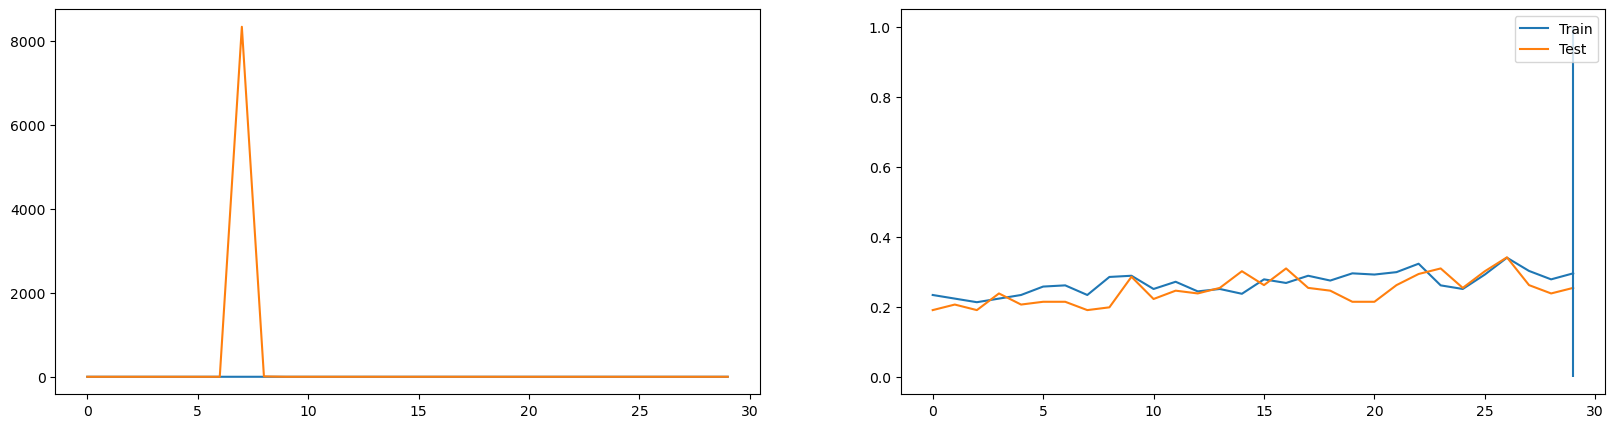

In [8]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(20,5))

axs[0].plot(df_history.index.values, df_history['loss'], label='Train')
axs[0].plot(df_history.index.values, df_history['val_loss'], label='Test')

axs[1].plot(df_history.index.values, df_history['accuracy'], label='Train')
axs[1].plot(df_history.index.values, df_history['val_accuracy'], label='Test')

axs[0].vlines(EPOCHS-1, min(df_history['loss']), max(df_history['loss']))
axs[1].vlines(EPOCHS-1, 0, 1)

plt.legend()

plt.show()

In [9]:
if OPTION == 0:
    model.save('xception_model.h5')
    df_history.to_csv('xception_train.csv')
else:
    model.save('xception_without_model.h5')
    df_history.to_csv('xception_without_train.csv')